In [107]:
%pip install backtesting --quiet
%pip install xgboost --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Basics 
import pandas as pd
import numpy as np
import yfinance as yf
import os
from datetime import timedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import seaborn as sns

import joblib
import warnings

# ML
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# OOP/ETC
from pipeline import Pipeline
from backtesting import Backtest, Strategy

# Part A - Data Preprocessing

Feature engineering.

**Technical Analysis (TA)** <br>

&#9675; **Moving Average Differential/Spread (`50_20_ma_spread`)**  
  Difference between short-term and long-term moving averages; helps determine directional momentum.  
  If short-term MA > long-term MA = **Bullish** momentum, else **Bearish** momentum.

&#9675; **Exponentially Weighted Volatility (`MSFT_ewm`)**  
  Measures recent volatility with more emphasis on recent returns.  
  Captures regime shifts and fast-changing market risk more responsively than simple rolling volatility.

&#9675; **Log Returns (`*_logreturns`)**  
  Continuous returns used to normalize price changes across assets and maintain time-additivity:
  - `MSFT_logreturns` – Microsoft  
  - `SPY_logreturns` – S&P 500 ETF  
  - `^VIX_logreturns` – Volatility Index  
  - `^TNX_logreturns` – 10-Year Treasury Yield  
  - `XLK_logreturns` – Technology Select Sector ETF

**Supplement Tickers** <br>

&#9675; **SPY** – ETF of the S&P 500; provides overall market direction.  
Features: `SPY_logreturns`, `SPY_volume`

&#9675; **^VIX** – CBOE Volatility Index; reflects implied volatility on SPY options and is often referred to as the "fear gauge".  
Feature: `^VIX_logreturns`

&#9675; **^TNX** – 10-Year Treasury Yield; rising yields signal inflationary pressure and impact equity risk premiums.  
Feature: `^TNX_logreturns`

&#9675; **XLK** – Technology sector ETF; contextualizes sector-specific behavior (especially for MSFT).  
Features: `XLK_logreturns`, `XLK_volume`

&#9675; **MSFT Volume (`MSFT_volume`)** – Total shares traded daily; proxy for liquidity and interest in MSFT.

&#9675; **SPY Volume (`SPY_volume`)** – Market-wide volume benchmark.

&#9675; **Target** – Binary or categorical prediction target (e.g., next-day movement).


In [4]:
pipeline = Pipeline(start='1999-01-01', end='2025-01-03')
df = pipeline.prepare_data

In [5]:
df

MSFT_logreturns  SPY_logreturns  XLK_logreturns  MSFT_ewm  \
Date                                                                    
1999-03-16         0.019034       -0.003818        0.017020  0.007388   
1999-03-17        -0.011527       -0.004312       -0.006512  0.005497   
1999-03-18         0.031293        0.015959        0.013841  0.008076   
1999-03-19        -0.007275       -0.017144       -0.024349  0.006541   
1999-03-22         0.009448        0.001927        0.000000  0.006832   
...                     ...             ...             ...       ...   
2024-12-24         0.009330        0.011054        0.010280  0.000338   
2024-12-26        -0.002781        0.000067        0.000665  0.000026   
2024-12-27        -0.017453       -0.010582       -0.013384 -0.001722   
2024-12-30        -0.013328       -0.011477       -0.012798 -0.002882   
2024-12-31        -0.007869       -0.003645       -0.008351 -0.003381   

                  VIX    TNX  50_20_ma_spread  MSFT_volume  SPY_volume  \
Date                                                                     
1999-03-16  25.150000  5.097         0.266955     68554000     4547500   
1999-03-17  25.570000  5.122         0.215714     44919600     4524100   
1999-03-18  24.129999  5.101         0.090488     56231200     3506300   
1999-03-19  24.320000  5.148        -0.028211     91980400     5526700   
1999-03-22  25.000000  5.194        -0.143936     55719200     4603800   
...               ...    ...              ...          ...         ...   
2024-12-24  14.270000  4.591       -12.136489      7164500    33160100   
2024-12-26  14.730000  4.579       -12.238155      8194200    41219100   
2024-12-27  15.950000  4.619       -12.310185     18117700    64969300   
2024-12-30  17.400000  4.545       -12.200056     13158700    56578800   
2024-12-31  17.350000  4.573       -11.643664     13246500    57052700   

            XLK_volume  Target  
Date                            
1999-03-16      758800     0.0  
1999-03-17      425400     1.0  
1999-03-18      321400     0.0  
1999-03-19      636500     1.0  
1999-03-22      773500     0.0  
...                ...     ...  
2024-12-24     2326700     0.0  
2024-12-26     3575400     0.0  
2024-12-27     4363200     0.0  
2024-12-30     3975200     0.0  
2024-12-31     4690600     0.0  

[6492 rows x 11 columns]

# Part B - EDA + Viz

Viz univariate timeseries.

In [6]:
os.makedirs('media', exist_ok = True)

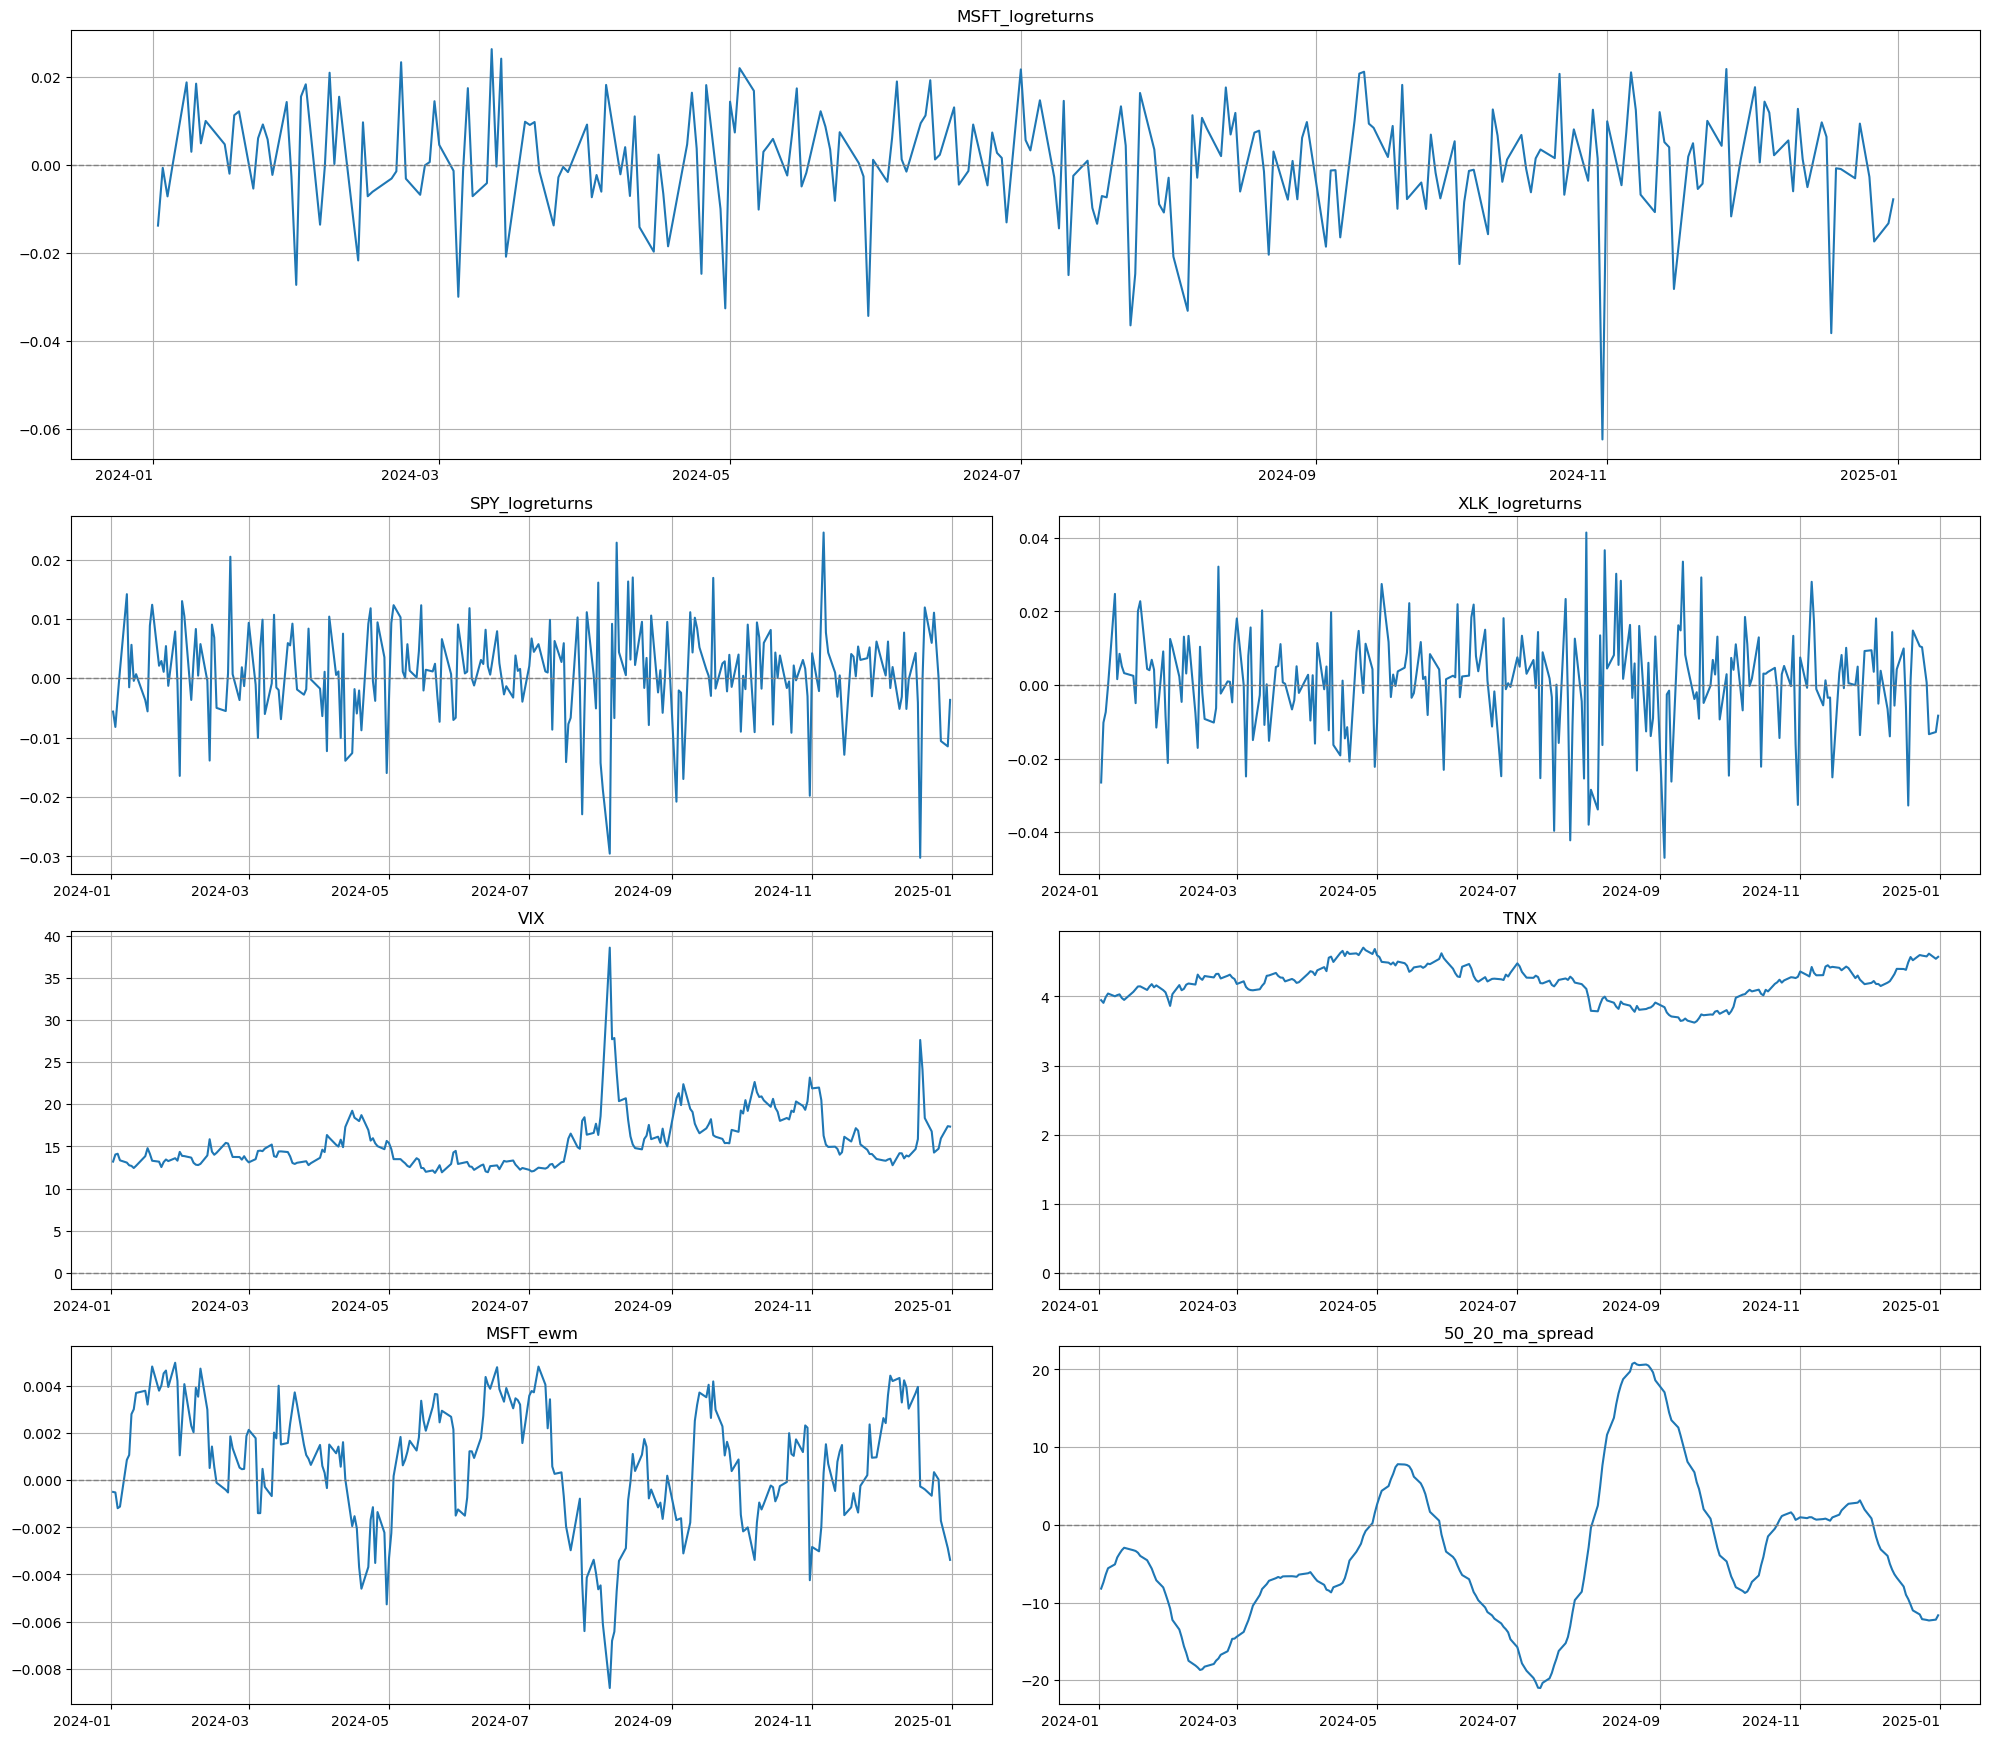

In [7]:
cols_to_plot = ['MSFT_logreturns', 'SPY_logreturns', 'XLK_logreturns', 'VIX', 'TNX','MSFT_ewm', '50_20_ma_spread']

fig = plt.figure(figsize=(20, 18))
gs = gridspec.GridSpec(4, 2, height_ratios=[1.2, 1, 1, 1])

ax0 = fig.add_subplot(gs[0, :])
df.loc['2024-01-01':, 'MSFT_logreturns'].plot(ax=ax0, title='MSFT_logreturns')
ax0.axhline(y=0, color='gray', linestyle='--', linewidth=1)
ax0.grid(True)
ax0.set_xlabel("")
ax0.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax0.tick_params(axis='x', labelrotation=0)
other_cols = cols_to_plot[1:]
for i, col in enumerate(other_cols):
    row = (i // 2) + 1
    col_idx = i % 2
    ax = fig.add_subplot(gs[row, col_idx])
    df.loc['2024-01-01':, col].plot(ax=ax, title=col)
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=1)
    ax.grid(True)
    ax.set_xlabel("")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.tick_params(axis='x', labelrotation=0)
plt.tight_layout()
plt.subplots_adjust(bottom=0.05)
plt.savefig('media/univariate_viz')
plt.show()

Correlation between returns.

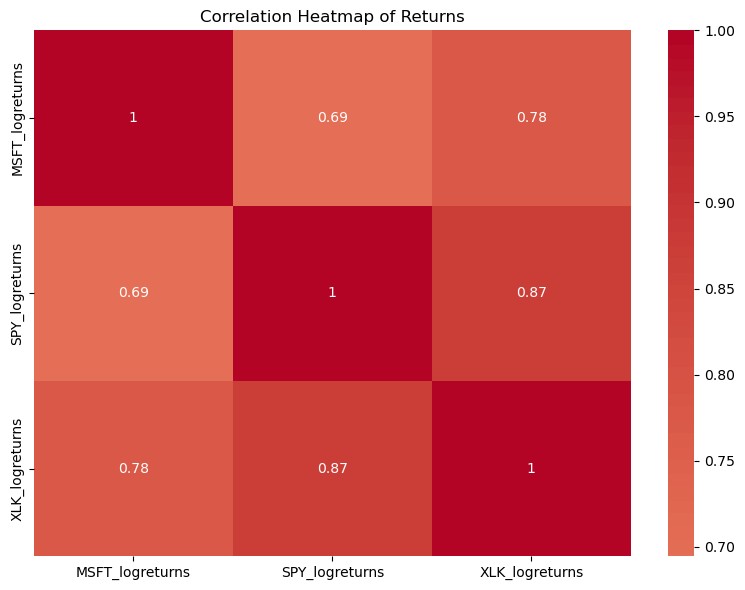

In [8]:
returns_cols = ['MSFT_logreturns', 'SPY_logreturns', 'XLK_logreturns']
corr_matrix = df[returns_cols].corr() # Compute correlation matrix

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap of Returns")
plt.tight_layout()
plt.savefig('media/correlation_heatmap')
plt.show()

**Correlation Insight**

There exists a **high degree of correlation** among the tickers **MSFT**, **SPY**, and **XLK**, which is both expected and economically intuitive:

- **MSFT** is a large-cap technology stock and a major component of both the **S&P 500** and the **XLK** ETF (which tracks the technology sector). As such, it is naturally correlated with XLK.
- **SPY** is an ETF that mirrors approximately **1/10th of the S&P 500**. Since MSFT is one of the top-weighted constituents of the index, its returns closely track both SPY and the broader market.

This high correlation reflects the **systematic exposure of MSFT** to both sectoral and macroeconomic movements.


**Modeling Implication**

This observed multicollinearity can negatively impact models that assume feature independence or rely on stable coefficient estimation.

- **Linear models** such as **Ordinary Least Squares (OLS)** or **Logistic Regression** may perform poorly in this setting, as their coefficient estimates become unstable or hard to interpret.
- To mitigate this, we can apply **Principal Component Analysis (PCA)** to transform the correlated features into a smaller set of **uncorrelated principal components**, capturing the directions of greatest variance while eliminating redundancy.

This preprocessing step allows us to **retain predictive power** while making the feature set more compatible with linear modeling assumptions.

In [9]:
#====SPLIT DATA & SCALE====
split_dict = pipeline.split(df=df, train_proportion=0.90,scale=True)
X_tr_scaled = split_dict['X_tr_scaled']
X_ts_scaled = split_dict['X_ts_scaled']
y_tr = split_dict['y_tr']
y_ts = split_dict['y_ts']

## PCA

In [10]:
pca = PCA()
X_train_pca = pca.fit_transform(X_tr_scaled)
X_test_pca = pca.transform(X_ts_scaled)

X_test_pca = pd.DataFrame(X_test_pca, columns=[f'PCA_{i}' for i in range(1, X_test_pca.shape[1] + 1)])
X_train_pca = pd.DataFrame(X_train_pca, columns=[f'PCA_{i}' for i in range(1, X_train_pca.shape[1] + 1)])

In [11]:
X_train_pca

PCA_1     PCA_2     PCA_3     PCA_4     PCA_5     PCA_6     PCA_7  \
0     1.522428  1.617333  0.440372 -0.862790  1.354165  0.733215 -0.656421   
1    -0.041436  1.667386 -0.596430 -0.447205  1.148139  1.086291 -0.246002   
2     2.675946  1.436157  0.629456 -0.671650  1.088420  0.873251 -0.449296   
3    -1.087124  2.166156 -0.514322 -1.344837  1.908990  0.190711 -0.860339   
4     1.012536  1.602544 -0.059087 -0.751689  1.227122  0.893200 -0.443867   
...        ...       ...       ...       ...       ...       ...       ...   
5838  0.307922  0.551552  2.487928  4.647636  1.807823  1.087149 -0.573619   
5839  1.311490  0.411596  2.810181  4.888166  1.741303  1.020572 -0.591187   
5840  2.417444  0.232720  3.039898  4.659587  2.081459  0.864651 -0.628797   
5841 -1.003441  0.576187  1.699233  4.297703  3.058268  0.588318 -0.845864   
5842 -0.646081  0.772476  1.503540  4.394678  3.054280  0.967235 -0.595355   

         PCA_8     PCA_9    PCA_10  
0     0.387982 -0.007584  0.819395  
1     0.180043 -0.852329  0.066047  
2     0.384109 -0.307241 -0.419956  
3     0.080002  0.010981 -0.190125  
4     0.380263 -0.445599 -0.157423  
...        ...       ...       ...  
5838 -0.780764 -0.064767  0.052518  
5839 -0.920576 -0.648654  0.088719  
5840 -0.787973 -0.531827  0.172243  
5841 -0.670698 -0.286882  0.065521  
5842 -0.557771  0.096815  0.298762  

[5843 rows x 10 columns]

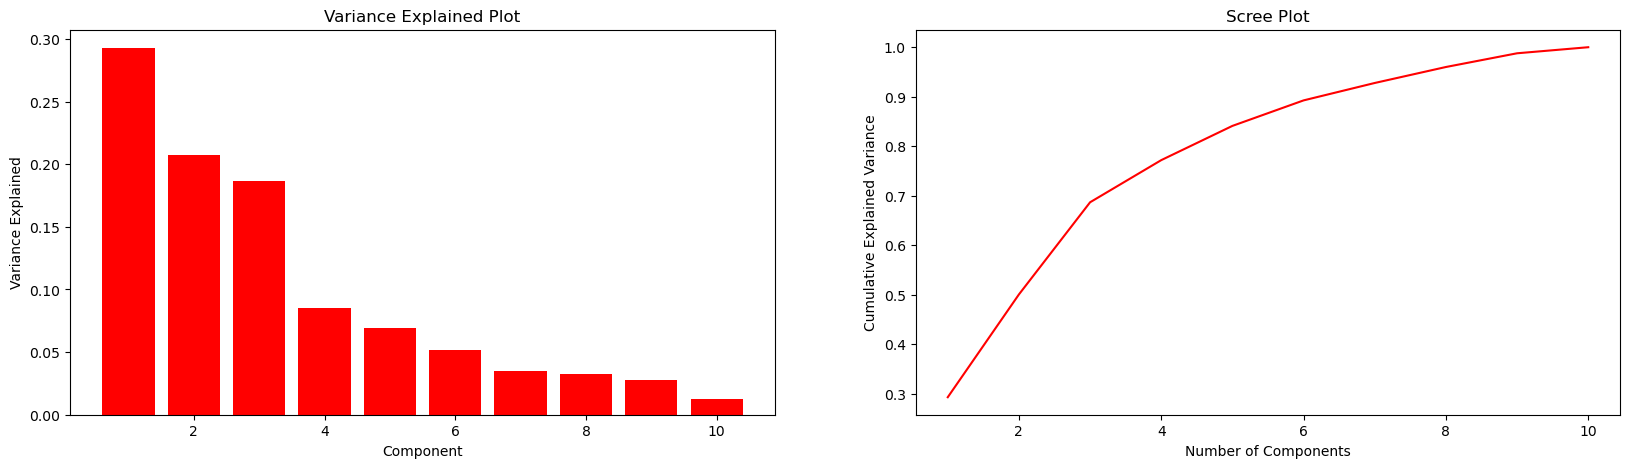

PC1 and PC2 explain 50.047% of the variance.


In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].bar(np.arange(1, X_train_pca.shape[1] + 1), pca.explained_variance_ratio_, color='red')
ax[0].set_xlabel('Component')
ax[0].set_ylabel('Variance Explained')
ax[0].set_title('Variance Explained Plot')

ax[1].plot(
    np.arange(1, len(pca.explained_variance_ratio_) + 1),
    np.cumsum(pca.explained_variance_ratio_),
    color='red'
)
ax[1].set_xlabel('Number of Components')
ax[1].set_ylabel('Cumulative Explained Variance')
ax[1].set_title('Scree Plot')

plt.savefig('media/pca_var_explained_and_screeplot.png')
plt.show()

print(f'PC1 and PC2 explain {np.sum(pca.explained_variance_ratio_[:2]) * 100:.3f}% of the variance.')

**PCA Visualization & Label Separation Insight**

After projecting the training data into the first two principal components and coloring by the target labels (buy = green, sell = red), we observe **substantial overlap between classes**. There is no clear visual separation in PCA space.

This result is expected and highlights a fundamental point:

- **PCA is an unsupervised technique** designed to capture directions of **maximum variance**, not necessarily the directions that best separate classes.
- In many real-world applications — especially in **financial data** — the signal-to-noise ratio is low. Price-based indicators and market-derived features often contain high variance driven by noise, macro shocks, or crowd behavior, not necessarily predictive structure.

This means that:
- **Poor class separation in PCA space doesn't imply useless features**, but rather that **PCA isn't optimized for classification**.
- If the problem of separating buy/sell signals were trivially solved by PCA, then anyone could generate alpha with a few matrix operations — and **markets would be instantly arbitraged**.

This reinforces the importance of:
- Trying **nonlinear dimensionality reduction techniques** like **UMAP** or **t-SNE**
- Using supervised learning models that directly optimize for classification accuracy
- Continuing to **engineer richer features** grounded in domain knowledge



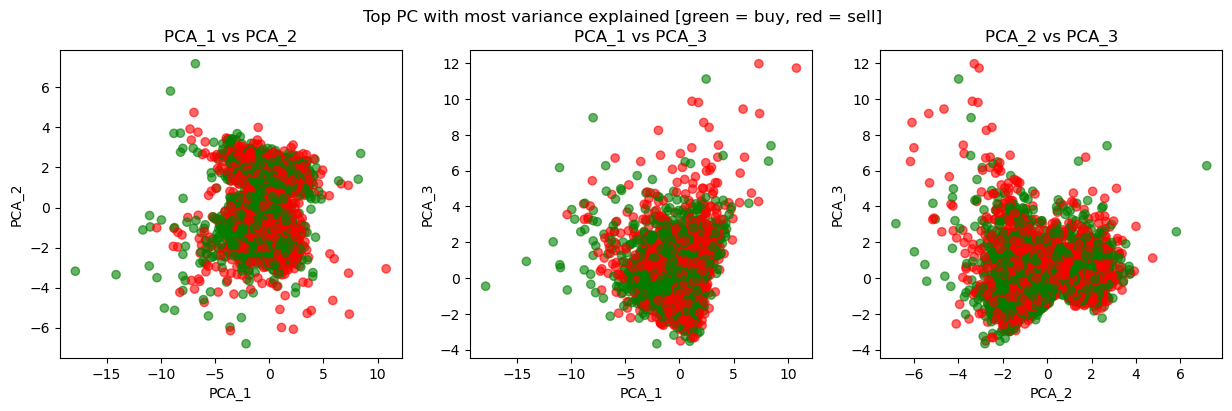

In [13]:
y_tr_series = pd.Series(y_tr)
colors = y_tr_series.map({1: 'green', 0: 'red'})  # green is buy, red is sell

fig, ax = plt.subplots(1,3,figsize = (15,4))

for k, i in enumerate([(1,2), (1,3), (2,3)]):
    pc_a = f'PCA_{i[0]}'
    pc_b = f'PCA_{i[1]}'
    ax[k].scatter(X_train_pca[pc_a], X_train_pca[pc_b], c=colors, alpha=0.6)
    ax[k].set_xlabel(pc_a)
    ax[k].set_ylabel(pc_b)
    ax[k].set_title(f'{pc_a} vs {pc_b}')

plt.suptitle('Top PC with most variance explained [green = buy, red = sell]')
plt.savefig('media/pca_2d_scatter.png')
plt.show()

## UMAP

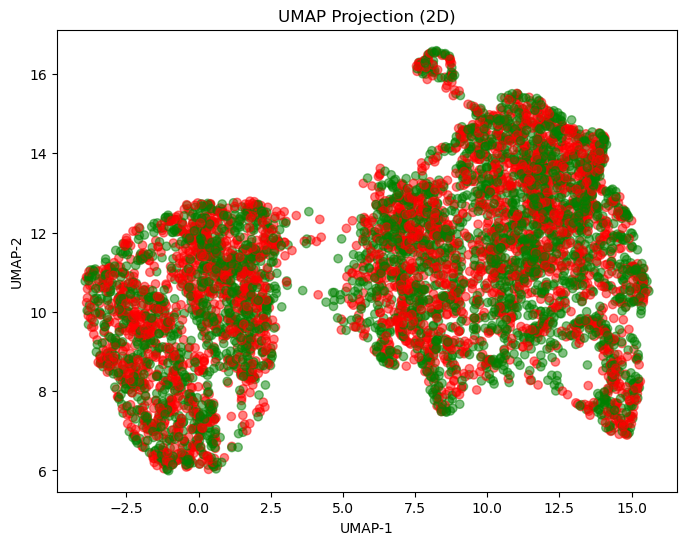

In [14]:
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.3, n_jobs=-1) # Fit UMAP
X_umap = umap_model.fit_transform(X_tr_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=colors, alpha=0.5)
plt.title('UMAP Projection (2D)')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')

plt.savefig('media/umap_label_projection.png')
plt.show()

# Part C - Model

### Random Forest

In [ ]:
# Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 20, 30],
    'min_samples_leaf': [1, 2, 5, 10, 50],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2', 0.5]
}

rf_model = RandomForestClassifier()
cv = TimeSeriesSplit(n_splits=3)
model = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=cv, n_jobs=-1).fit(X=X_tr_scaled,y=y_tr)
best_params = model.best_estimator_.get_params()

best_params_subset = {key:best_params[key] for key in param_grid.keys()}
best_accuracy = model.best_score_

print(f"""The best params were {best_params_subset}.
The best accuracy in this grid of params = {best_accuracy*100:.2f}% - we see slight improvements.""")

/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The best params were {'n_estimators': 500, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'max_features': 'log2'}.
The best accuracy in this grid of params = 53.15% - we see slight improvements.


In [ ]:
os.makedirs('models', exist_ok = True)
joblib.dump(model.best_estimator_, 'models/rf_best_model.joblib') # Saving the best model from GridSearchCV

['models/rf_best_model.joblib']

### XGBoost

In [27]:
warnings.filterwarnings("ignore", category=UserWarning)

xgb_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 20, 30],
    'min_child_weight': [1, 2, 5, 10, 50],
    'gamma': [0, 0.1, 0.5],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'subsample': [0.7, 1.0],
    'learning_rate': [0.01, 0.05, 0.1]
}

cv = TimeSeriesSplit(n_splits=3)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=cv, n_jobs=-1, scoring='accuracy')
model.fit(X_tr_scaled, y_tr)

best_params = model.best_estimator_.get_params()
best_params_subset = {key: best_params[key] for key in xgb_param_grid.keys()}
best_accuracy = model.best_score_

print(f"The best params were {best_params_subset}.\nThe best accuracy in this grid of params = {best_accuracy*100:.2f}% - we see slight improvements.")

joblib.dump(model.best_estimator_, 'models/xgb_best_model.joblib')

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:26:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:26:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:26:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:26:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

The best params were {'n_estimators': 500, 'max_depth': 10, 'min_child_weight': 10, 'gamma': 0, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.05}.
The best accuracy in this grid of params = 52.56% - we see slight improvements.


['models/xgb_best_model.joblib']

### Gradient Boosting

In [32]:
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 10],
    'subsample': [0.7, 1.0],
    'max_features': ['sqrt', 'log2']
}

cv = TimeSeriesSplit(n_splits=3)
gb_model = GradientBoostingClassifier()

model = GridSearchCV(estimator=gb_model, param_grid=gb_param_grid, cv=cv, n_jobs=-1, scoring='accuracy')
model.fit(X_tr_scaled, y_tr)

best_params = model.best_estimator_.get_params()
best_params_subset = {key: best_params[key] for key in gb_param_grid.keys()}
best_accuracy = model.best_score_

print(f"The best params were {best_params_subset}.\nThe best accuracy in this grid of params = {best_accuracy*100:.2f}% - we see slight improvements.")

joblib.dump(model.best_estimator_, 'models/gb_best_model.joblib')

The best params were {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 10, 'subsample': 0.7, 'max_features': 'log2'}.
The best accuracy in this grid of params = 52.83% - we see slight improvements.


['models/gb_best_model.joblib']

### Logistic Regression

In [30]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]
}

cv = TimeSeriesSplit(n_splits=3)
ridge_logreg = LogisticRegression(penalty='l2', solver='liblinear') # ridge regularized

model = GridSearchCV(estimator=ridge_logreg, param_grid=param_grid, cv=cv, n_jobs=-1, scoring='accuracy')
model.fit(X_train_pca, y_tr)

best_params = model.best_estimator_.get_params()
best_params_subset = {key: best_params[key] for key in param_grid.keys()}
best_accuracy = model.best_score_

print(f"The best params were {best_params_subset}.\nThe best accuracy in this grid of params = {best_accuracy*100:.2f}% - we see slight improvements.")

joblib.dump(model.best_estimator_, 'models/logreg_pca_best_model.joblib')

The best params were {'C': 0.01}.
The best accuracy in this grid of params = 51.99% - we see slight improvements.


['models/logreg_pca_best_model.joblib']

### Evaluate

In [39]:
# Load models
xgb = joblib.load('models/xgb_best_model.joblib')
rf = joblib.load('models/rf_best_model.joblib')
gb = joblib.load('models/gb_best_model.joblib')
logreg = joblib.load('models/logreg_pca_best_model.joblib')

# Evaluate on test data
models = {
    "XGBoost": xgb,
    "Random Forest": rf,
    "Gradient Boosting": gb,
    "LogReg (PCA)": logreg
}

for name, model in models.items():
    print("="*50)
    print(f"{name} Evaluation")
    print("="*50)
    
    if name == "LogReg (PCA)":
        y_pred = model.predict(X_test_pca)
    else:
        y_pred = model.predict(X_ts_scaled)
    
    acc = accuracy_score(y_ts, y_pred)
    print(f"Accuracy: {acc*100:.2f}%")
    print("Confusion Matrix:")
    print(confusion_matrix(y_ts, y_pred))
    print("Classification Report:")
    print(classification_report(y_ts, y_pred, digits=4))
    print("\n\n")



XGBoost Evaluation
Accuracy: 48.69%
Confusion Matrix:
[[150 161]
 [172 166]]
Classification Report:
              precision    recall  f1-score   support

         0.0     0.4658    0.4823    0.4739       311
         1.0     0.5076    0.4911    0.4992       338

    accuracy                         0.4869       649
   macro avg     0.4867    0.4867    0.4866       649
weighted avg     0.4876    0.4869    0.4871       649




Random Forest Evaluation
Accuracy: 50.85%
Confusion Matrix:
[[ 76 235]
 [ 84 254]]
Classification Report:
              precision    recall  f1-score   support

         0.0     0.4750    0.2444    0.3227       311
         1.0     0.5194    0.7515    0.6143       338

    accuracy                         0.5085       649
   macro avg     0.4972    0.4979    0.4685       649
weighted avg     0.4981    0.5085    0.4746       649




Gradient Boosting Evaluation
Accuracy: 52.54%
Confusion Matrix:
[[112 199]
 [109 229]]
Classification Report:
              precision 

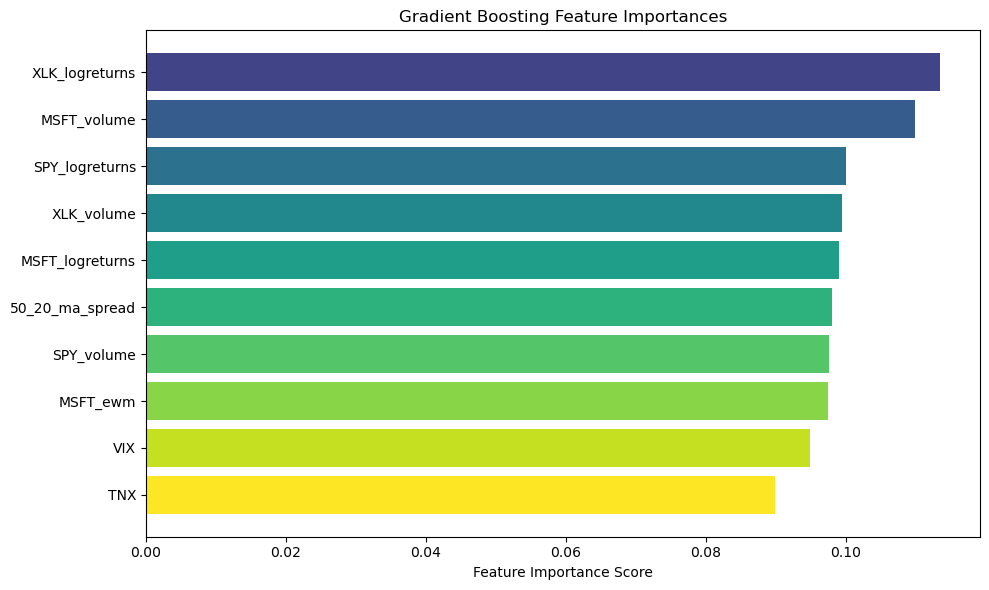

In [50]:
feature_names = df.columns
importances = gb.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
sorted_features = np.array(feature_names)[sorted_idx]
sorted_importances = importances[sorted_idx]
colors = plt.cm.viridis(np.linspace(0.2, 1, len(sorted_importances)))

plt.figure(figsize=(10, 6))
bars = plt.barh(sorted_features, sorted_importances, color=colors)
plt.xlabel("Feature Importance Score")
plt.title("Gradient Boosting Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("media/gb_feature_importance_colored.png", dpi=300)
plt.show();


# Back Test Best Model

In [101]:
test_dates = df.iloc[-len(X_ts_scaled):,:].index
raw_data = yf.download('MSFT', start=test_dates[0], end=test_dates[-1]+ timedelta(days=1), multi_level_index=False)

[*********************100%***********************]  1 of 1 completed


In [ ]:
bt_df = raw_data.copy()
bt_df['Signal'] = y_pred
bt_df['Signal'] = bt_df['Signal'].shift(1)
bt_df.dropna(inplace=True)

class MySignalStrategy(Strategy):
    def init(self):
        self.signal = self.data.Signal

    def next(self):
        if self.signal[-1] == 1 and not self.position:  # Buy signal
            self.buy()
        elif self.signal[-1] == 0 and self.position:    # Sell signal
            self.position.close()

bt = Backtest(bt_df, MySignalStrategy, cash=100_000, commission=0.0)
results = bt.run()
bt.plot(plot_equity=True)
bt.plot(filename='media/gb_backtest.html')

Backtest.run:   0%|          | 0/647 [00:00<?, ?bar/s]

GridPlot(id='p1861', ...)

GridPlot(id='p2037', ...)